In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fsolve
import time as time

In [2]:
import algos_QP
import RandomWalk
from RandomWalk import Random_walk

In [3]:
reload(algos_QP)
reload(RandomWalk)

<module 'RandomWalk' from 'RandomWalk.pyc'>

In [4]:
nState=1000
nStep=100
nFeatures=100
gamma=0.9

P_pi,r_pi=Random_walk.compute_policy(nState,nStep)
Phi=Random_walk.compute_features(nState,nFeatures)

d_init=(1.0/nState)*np.ones(nState+1)
d_init[0]=0.0
problem=Random_walk(gamma=gamma,nState=nState,nStep=nStep,nAction=nState,nFeatures=nFeatures,
                    behaviour_policy=P_pi,r_pi=r_pi,d_init=d_init)

RandomWalk.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(behaviour_policy==None):
algos_QP.py:322: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(x_init==None):


In [50]:
nIter=25000

verbose=True

algos=['TD','TDC','TDC','TDC_AdaGrad','LSTD']
lbl=['TD(0)','TDC','TDC w/ momentum','TDC / AdaGrad','LSTD']


nAlgos=len(algos)
com=['' for i in range(nAlgos)]

alpha=0.01*np.ones(nAlgos)
beta=0.05*np.ones(nAlgos)
momentum=['None' for i in range(nAlgos)]
momentum[2]='Regular'

theta=np.zeros((nAlgos,nIter+1,nFeatures+1))

for algo in enumerate(algos):
    #problem.restart()
    #np.random.seed(0)
    theta[algo[0],:]=problem.run_algo(algo[1],nIter_max=nIter,verbose=verbose,
                                   alpha_=alpha[algo[0]],beta_=beta[algo[0]],
                                   momentum=momentum[algo[0]],
                                   epsilon_LSTD=10.)
    


Algo: TD 	 | Time (s): 0.820835643159
Algo: TDC 	 | Time (s): 0.958230827571
Algo: TDC 	 | Time (s): 0.963034234477
Algo: TDC_AdaGrad 	 | Time (s): 1.07015088869
Algo: LSTD 	 | Time (s): 2.01502919733


In [51]:
#compute value function
v=np.zeros((nAlgos,nIter+1,problem.nState+1))
for algo in range(nAlgos):
    v[algo,:]=((problem.Phi).dot(theta[algo,:].T)).T
    
#compute true TD fixed point
#theta_TD_star = np.linalg.inv(problem.A_approx).dot(problem.b_approx)
n,t,v_TD_star=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=gamma,
            algo='CG',nIter_max=nIter,x_init_=None,
            verbose=False,history=False,preconditionner=False)

#compute history of MSVE
MSPBE=np.zeros((nAlgos,nIter+1))
for algo in range(nAlgos):
    #MSVE[algo,:]=np.sum((problem.d_stationnary)*(v[algo,:]-v_TD_star)*(v[algo,:]-v_TD_star),1)
    MSPBE[algo,:]=problem.MSPBE(theta[algo,:])

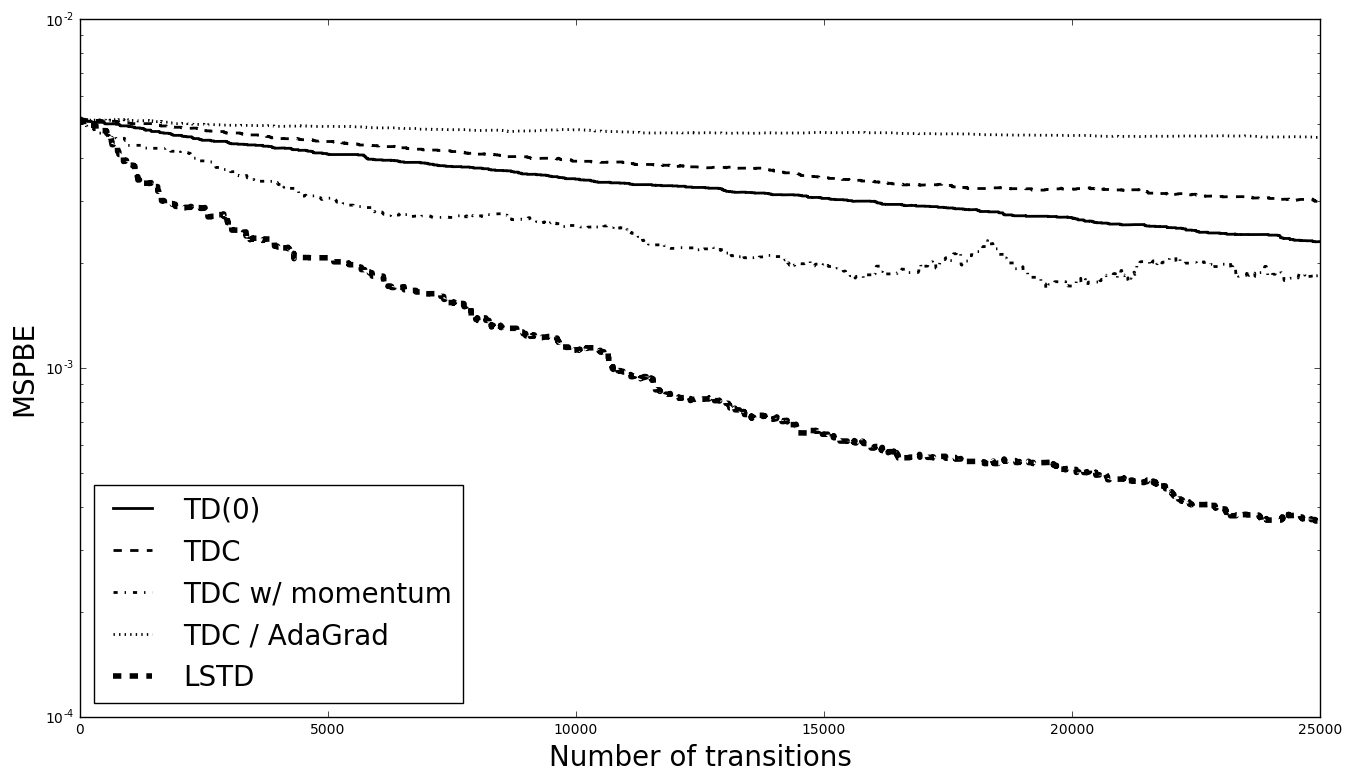

In [56]:
#plot learning curves
style=['-','--','-.',':','--']
width=[2,2,2,2,4]

plt.figure(figsize=[16,9])

for algo in range(nAlgos):
    plt.semilogy(MSPBE[algo,:],label=lbl[algo],ls=style[algo%5],lw=width[algo],color='k')
    #plt.plot(nRuns*np.arange(nIter+1),MSPBE[algo,:],color='pink')
    

plt.legend(loc=3,fontsize=20)
plt.xlabel('Number of transitions',fontsize=20)
plt.ylabel('MSPBE',fontsize=20)


plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Report\images\GTD.png', bbox_inches='tight')

plt.show()